In [67]:
import pickle

import numpy

# Load model
MODEL_PATH = 'pose_lsvc_acc84.model'
SCALER_PATH = 'pose_lsvc_acc84.scaler'

with open(MODEL_PATH, 'rb') as f:
    model = pickle.load(f)
  
with open(SCALER_PATH, 'rb') as f:
    scaler = pickle.load(f)  
    

In [68]:
categories = {
    0: "back bowled",
    1: "back too low",
    2: "correct",
    3: "knees inward",
    4: "knees too far forward",
    5: "legs not far",
    6: "legs too far",
    7: "not deep enough",
    8: "too deep enough"
}

In [69]:
from sklearn.preprocessing import StandardScaler
import numpy as np


def preprocess_pose(df):
    # Normalize data
    pose_mean = df.stack().mean()
    pose_std = df.stack().std()
    df = (df - pose_mean) / pose_std
    return df


# Model predict function, includes reshape
def predict(input_pose):
    # Reshape
    input_pose = np.array([input_pose])

    # reshape into 2d
    nsamples, nx, ny = input_pose.shape
    input_pose_reshaped = input_pose.reshape((nsamples, nx * ny))

    # input_pose_reshaped = input_pose
    
    # scaling
    # scaler = StandardScaler()
    # s = np.sqrt(scaler.var_)
    # m = scaler.mean_
    
    print(input_pose_reshaped)
    # print(m)
    # input_pose_scaled = (np.array([input_pose_reshaped] - m)) / s 
    input_pose_scaled = scaler.transform(input_pose_reshaped.astype(np.float32))

    prediction = model.predict(input_pose_scaled)

    return prediction


In [70]:
import pandas as pd


def convert_to_df(input_pose):
    new_pose = []
    landmarks = input_pose.pose_world_landmarks.landmark
    for point in landmarks:
        new_pose.append(numpy.array([point.x, point.y, point.z]))

    return pd.DataFrame(new_pose)

In [71]:
def convert_and_predict(input_pose):
    return predict(preprocess_pose(convert_to_df(input_pose)))

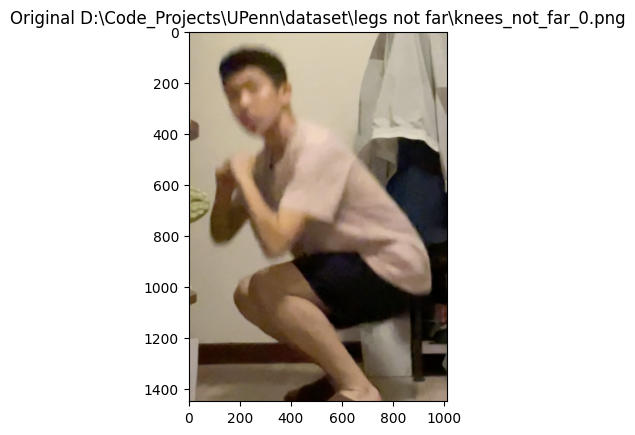

[[-0.66191452 -1.30556021 -0.19881328 -0.65964322 -1.47738015 -0.18169422
  -0.65919325 -1.48050829 -0.17727727 -0.6628123  -1.47973276 -0.1789251
  -0.76461902 -1.42728485 -0.10877567 -0.7656972  -1.43087896 -0.11415592
  -0.77002753 -1.43521283 -0.11245516 -0.23073607 -1.51360238  0.11599658
  -0.72189844 -1.34283201  0.36875173 -0.46141513 -1.23937841 -0.09005614
  -0.59885558 -1.18090625 -0.01273209  0.34682162 -0.69025051  0.01114426
  -0.59814294 -0.6757186   0.80133238 -0.17600962  0.29022397 -0.12170955
  -1.02944174  0.25022411  0.35621811 -0.65580691 -0.33625644  0.01094157
  -0.8032066  -0.0975073  -0.53630531 -0.79101659 -0.45632228 -0.0547424
  -0.71074961 -0.1931116  -0.63268874 -0.68649457 -0.61839591 -0.03584824
  -0.62060797 -0.32043126 -0.5521923  -0.62319195 -0.42562215  0.03533154
  -0.70454185 -0.16581638 -0.52940808  1.23010386  0.90151276  0.66528276
   0.63706989  0.96822385  1.20954862 -0.45200549  1.23016909  0.3798422
  -0.66516451  1.26849393  1.34499745  0.

D:\Code_Projects\UPenn\PoseClassifier\.venv\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [76]:
import cv2
import matplotlib.pyplot as plt

import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose


img_filepath = r"D:\Code_Projects\UPenn\dataset\legs not far\knees_not_far_0.png"

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    # Currently just use images
    # Make detection
    img = cv2.imread(img_filepath)
    
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    
    # show original image
    plt.imshow(image)
    plt.title(f"Original {img_filepath}")
    plt.show()
    
    # Make detection
    results = pose.process(image)

    # AI now, eepy!!!1!!11!
    # but first data restructure
    detected = False
    try:
        _ = results.pose_world_landmarks.landmark
        detected = True
    except KeyError:
        detected = False
    
    if detected:
        prediction_output = convert_and_predict(results)
        print(prediction_output)
        print(f"{categories[prediction_output[0]]}")